<a href="https://colab.research.google.com/github/saminehbagheri/Recommender-System/blob/master/Simple_Recommender_System_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Recommender System in Python

# What are we going to find in this notebook?
* [What Is A Recommender System ?](#RS)
* [Content-Based Recommender System](#CBRS)
* [A Real-World Dataset](#RWDT)
* [Matrix Factorization Based Recommender System](#MF)
 * [Programming A Movie Recommender In Python](#MFPy)
 * [Movie Recommender Demo](#demo)



<a id='RS'></a>
# What Is A Recommender System?

Recommender System as its name suggests is the name given to any software designed to recommend you objects (to purchase or to click on or even to watch) which are attractive to you with a high probability. Development of such system became a hot topic for software developers and machine learning engineers in the last years. 

Nowadays, many of us interact with recommender systems on a daily basis. If you have an account in Amazon or Netflix or many similar online services, you may have recieved suggestions that often fit your interest. This can vary from a movie suggested by Netflix or very various products suggested by Amazon. The targeted advertisements on Facebook or tergeted pop-up advertisements in your browser are also other examples of applications of recommender systems. Almost no two person recieves the exact same advertisements or suggestions on online platforms.  All these personalized suggestions and advertistments use recommender systems to find the best match for your interests according to your former ratings, purchase or clicks.

Although some of the suggestions that we receive from the existing automized recommender systems are very promising and suprisingly meet our interests, the opposite can also happen, as these systems are not perfect yet and their developments seems to have a long way ahead to improve. In this blog post I give you a brief overview about a subset of existing algorithms. I try to explain the *Matrix Factorization Collaborative Filtering algorithm* which is popular method used in many recommender systems,  step by step. I will show you how to programm this algorithm in Python and apply it on a toy problem to build a <a href="https://colab.research.google.com/drive/183a5zoC5DB38QnBh6rUl24sjlTZL-t-i" target="_blank">movie recommender system</a>. Building such simple systems on your own will help us to develop some insights about how the recommender systems interact with our data, as well as letting us know about the issues and weak points of such systems.


Some of different approaches that are often used for recommender systems can be listed as following.
* Content-Based Recommender System
* Collaborative Filtering
 * Matrix Factorization
 * Deep Learning
 * Similarity-Based Recommender System
   * Item-Based 
   * User-Based
* Hybrid

One of the most straight-forward approaches to find a suitable recommendation for users of a platform is the *Content-Based Recommender System* approach. This method determines a rating value $R_{ij}$ for a specific user $u_i$ giving to a sepcific object $o_j$ by using a feature vector $\vec{x}_i$ for the $i$-th user and a feature vector for the $j$-th object $\vec{\theta}_j$. We try to explain the idea of this approach in the [next section](#CBRS) with a very small example. The biggest problem with such algorithms is that we require to know the important features which have impact on the decisions each user make. It is really difficult to find such set of features. Even if we can define a reasonably good set of important features, the next big challenge is to rate this features for every single item and user. Such information is often not available or not practical to extract fully. Although many platforms have access to some information about the users might be used as features like age, gender etc, often these information are not enough to build good enough feature vectors.

*Collaborative Filtering* algorithms aim at finding the most suitable suggestions for users without taking any explicit features into account and instead they make their decisions only based on the former interaction of the users with the system. These interactions might be number of clicks, user's ratings, user's purchases, etc. There are many different types of *Collaborative Filtering* inclduing the similarity-based algorithms which use some mathematical measures to find similarities between items or users. The item-based similarity-based algorithms suggest the user $i$ who is buying the item $j$ the items which are the most similar to the item $j$. The user-based similarity-based algorithms recommend the user $i$, to take a look at the items bought by the users which have a great similaty to user $i$. If you are an amazon user, you have already experienced interacting with such a system which after your purchase tells you: "The item that you bought is often bought with ... and ... and ...", listing a few other items. There are many different measures for finding similarity, correlation or dependency between items and/or users including  correlation coefficient of Bravais Pearson, rank-correlation coefficient of Spearman, cosimus similarity, Jaccard coefficient, etc.

*Matrix Factorization* is a different collaborative filtering approach. The main idea behind the matrix factorization is to predict how the user $i$ would rate the item/movie $j$. This prediction is done based on former ratings given by all users. This algorithm is in some sense similar to the content-based method with this difference that we don't assume that the there are explicitly known features. We try to learn implicit features for all users and all objects by means of matrix factorization. I explian this method with more details and implement it in [Matrix Factorization](#MF) Section. 

Each of these methods have their own pros and cons and the real-world working recommender systems use a hybrid of different methods. But in this Blog-Post we stick to develop an understaing for the content-based algorithm and grasping the idea of Matrix Factorization and its implementation.


$\color{green}{\text{Before starting}}$ let's run the following cell to have all the required libraries for this notebook.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import numpy as np
import copy
import random
import scipy.io
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
#import pdb   #This library is used for debugging the code, otherwise it is not necessary. 
              #You can simply enter pdb.set_trace() somewhere in your code for debugging purposes.
    
# If you want to have direct access to the datasets and codes you can clone the following github repository    
! git clone https://github.com/saminehbagheri/Recommender-System.git
%cd Recommender-System  

C:\Users\bagheri\Recommender-System


fatal: destination path 'Recommender-System' already exists and is not an empty directory.


<a id='CBRS'></a>
# Content-Based Recommender System

Let's start with a simple example for the **content-based approach**. 

Let's imagine a tiny problem where we only have three users: Samineh, Markus and Peter. If we assume that the only important features for these users (of course in a very simplified scenario) are how much a movie is (1)romantic, (2) comedy  or (3) action, then we can assume a feature vector of size 3 for each user. $\vec{x}_i=\{interest~in~romance, interest~in~comdey, interest~in~action\}$. 

We had the chance to ask all of our three users to let us know about their interests by filling their feature vectors. They could have rated each element with 0 if they don't have any interest, 1 if they really care about that feature and 0.5 if their feeling is somewhere in between. 

Samineh just likes romance movies and dislikes action and comedy a lot so her feature matrix look like: $\vec{x_s}=[1,0,0]$. Markus likes comedy movies and is not into romance and action at all $\vec{x_m}=[0,1,0]$. Peter dislikes romance but loves action and doesn't mind if there is a sense of humor in the movies so his feature vector looks like: $\vec{x_p}=[0,0.5,1]$. Stacking all these feature vectors together makes the user feature matrix.  



In [0]:
USER=pd.DataFrame([( [1, 0, 0]), ( [0, 1, 0]), ( [0, 0.5, 1])], 
                  columns=['Samineh','Markus','Peter'],
                  index=['Romantic','Comedy','Action']);
print(USER)

          Samineh  Markus  Peter
Romantic        1     0.0      0
Comedy          0     1.0      0
Action          0     0.5      1


We have three movies in our system Titanic, Terminator and Home Alone and we want to figure out what is the best recommendation for each user. In order to do that we need to define a feature vector for each movie. We ask some expert to do that for us. Titanic is a very romantic movie and not funny or action at all so its fair if we rate its feature vector as $\vec{\theta}_{Titanic}=[1,0,0]$. Terminator is an action movie with very little essence of romance and comedy, so our movie expert filled the Terminator's feature vector as $\vec{\theta}_{Terminator}=[0.2,0.1,1]$. The home alone is a comedy movie $\vec{\theta}_{Home-alone}=[0.0,1,0.2]$. Stacking all of the movie features together will give a movie feature matrix.

In [0]:
ITEM=pd.DataFrame([( [1, 0, 0]), ( [0.2, 0.1, 1]), ( [0, 1, 0.2])],
                  columns=['Titanic','Terminator','Home Alone'],
                  index=['Romantic','Comedy','Action']);
print(ITEM)

          Titanic  Terminator  Home Alone
Romantic      1.0         0.0         0.0
Comedy        0.2         0.1         1.0
Action        0.0         1.0         0.2


The dot product of the $i$-th user feature vector $\vec{x}_i$ and the $j$-th movie feature $\vec{x}_j$ provides a sort of similarity measure. The larger the dot product $\vec{x_i}\cdot\vec{\theta_j}=R_{ij}$ is the likelier that the user $i$ is going to like the movie $j$. We can determine all the similarity measures for each user and item simply by multiplying the user feature matrix and the movie feature matrix, as follows:

In [0]:
print(ITEM.T.dot(USER))

            Samineh  Markus  Peter
Titanic         1.0     0.2    0.0
Terminator      0.0     0.6    1.0
Home Alone      0.0     1.1    0.2


So according to this simple system we can recommend Titanic to Samineh. To Markus we might recommend Home Alone first and as a second choice Terminator. Th best recommendation for Peter is the Terminator. 

I think it is already pretty clear that the main problem with the content-based recommnder systems is the missing information about the feature vectors. First of all it is  very complicated to consider all the important features explicitly. Moreover, it is almost impossible to weight all the features for all users and all items. [Matrix Factorization](#MF) tries to learn these feature matrices by using the exisitng ratings of users.  

<a id='RWDT'></a>
# Real-World Datasets
How do the real-world datasets (for recommender systems) often look like? The most common available sort of the data for  recommender systems are user's rating. The item-user rating matrix often is a huge but sparse matrix.
The dataset that we use in this blog-post is a movie-user rating dataset. 

We start with loading the data.
We use a dataset with 943 users and 1682 movies. The dataset is provided in mat format. In this mat file there are two matrices. Matrix Y and R. 

Y: contains the rating values. Each cell of this matrix can have integer values between 0 to 5. The cells with 0 are actually the unknowns. So, the cell $R_{ij}$=0 means the $i$-th user didn't give any rating for the $j$-th movie. The cells with any value between 1 to 5 are rated by users. Higher ratings represent higher interests.

R: a matrix having 0 or 1. This matrix has 0 values in the unknown cells and 1 for the cells where a rating is provided.

In [0]:
mat = scipy.io.loadmat('ex8_movies.mat')
movie_names = pd.read_csv('movie_ids.txt',delimiter=';',header=None)[1]
Y=mat['Y']
R=mat['R']
num_user=Y.shape[1]
num_movie=Y.shape[0]
overallRating=np.sum(np.where(Y==1,1,0))
print("number of users:"+str(num_user))
print("number of movies:"+str(num_movie))
print("The overall number of ratings done is: "+str(overallRating))
print("Only "+str(100*overallRating/(num_user*num_movie))+"%  of the matrix is filled")

number of users:943
number of movies:1682
The overall number of ratings done is: 6110
Only 0.3852152981541189%  of the matrix is filled


Let's take a look at the rating distribution. The following cell plotsd the frequency of the ratings in a bar-chart.

<Container object of 6 artists>

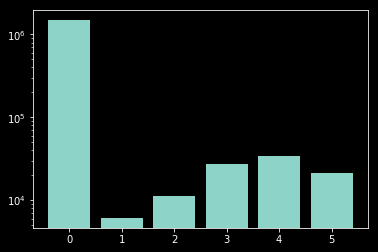

In [0]:
def howManyR(x):
    return np.sum(np.where(Y==x,1,0))
    
ratingFrequency=list(map(lambda x:np.sum(np.where(Y==x,1,0)), [0,1, 2, 3, 4,5]))
plt.style.use(['dark_background'])
plt.bar([0,1,2,3,4,5], ratingFrequency,log=True)

As we can see on the plot most of the elements of the rating matrix are zeros meaning that the rating matrix is very sparse. So most of the users did not rate most of the movies. The distribution of ratings is skewed to the right side meaning that there more good ratings and bad ones. In order to have a more clear idea about the percentage of ratings given by each user we make the following plot:

([], <a list of 0 Text xticklabel objects>)

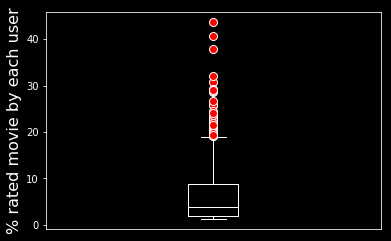

In [0]:
ratingPercentage=100*np.sum(R,axis=0)/Y.shape[0]
flierprops = dict(marker='o', markerfacecolor='r', markersize=8,
                  linestyle='none', markeredgecolor='w')
bp=plt.boxplot(ratingPercentage
               ,boxprops=dict(linewidth=1.0, color='white')
               ,whiskerprops=dict(linewidth=1.0, color='white')
               ,capprops=dict(linewidth=1.0, color='white')
               ,medianprops=dict(linewidth=1.0, color='white')
               ,flierprops=flierprops)
plt.ylabel('% rated movie by each user', fontsize=16)
plt.xticks([])

In the above plot we can see that most of the users rated less than 10 percent of the movies, although there are very few users who rated up to 40 percent of the movies.


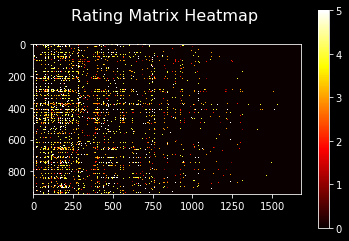

In [0]:
plt.imshow(Y.T, cmap='hot', interpolation='none')
plt.colorbar()
plt.title('Rating Matrix Heatmap \n', fontsize=16)
plt.show()

The heatmap plot shows the sparsness of the rating matrix clearly.

<a id='MF'></a>
# Matrix Factorization Collaborative Filtering

Recalling the content-based recommender system, the idea was to describe each item and each user with a vector of important features. In our example the feature vector we used had only three elements, but we are all aware that the there are way more important criteria than those three to impact our interest about a movie and sometimes these features can be more complicated than  simply the genre of the movie. Matrix Factorization assumes that we can describe a movie and a user in a form of a reletively large feature vector reasonably well. The main idea of Matrix Factorization is finding the proper user feature vector $\vec{x}_i$ and item feature vector $\vec{\theta}_j$ for all users $i=1\cdots n_u$ and movies $j=1\cdots n_m$ which their dot products gives a good estimation of the rating the $i$-th user would give for the $j$-th movie $y_{ij}$.

**Why this method is called matrix factorization?** As we already said in the ideal case of finding correct features, the dot product of the user feature vector and the movie feature vector should result in the rating: $\vec{x}_i\cdot\vec{\theta}_j=y_{ij}$. Assume that we stack all the user feature vectors together in user feature matrix $\mathbf{X}=\begin{bmatrix}-\vec{x}_1^T-\\ -\vec{x}_2^T- \\ \vdots \\-\vec{x}_{n_u}^T- \end{bmatrix}_{n_u \times n_f}$ and all the movie feature vectors together in the movie feature matrix $\mathbf{\Theta}=\begin{bmatrix}-\vec{\theta}_1^T-\\ -\vec{\theta}_2^T- \\ \vdots \\-\vec{\theta}_{n_m}^T- \end{bmatrix}_{n_m \times n_f}$. Then the rating matrix can be determined as follows: 



\begin{equation}\mathbf{\Theta} \cdot \mathbf{X}^T=\mathbf{R}\end{equation}
\begin{equation}\begin{bmatrix}- \vec{\theta}_1^T-\\ - \vec{\theta}_2^T- \\ \vdots \\- \vec{\theta}_{n_m}^T- \end{bmatrix} \cdot \begin{bmatrix}|&|&\cdots&|\\
               \vec{x_1}&\vec{x_2}&\cdots&\vec{x}_{n_u}\\
               |&|&\cdots&|\end{bmatrix}=\mathbf{R}\end{equation}

It would be perfect if we had the right feature matrices but we don't. What we actually have is the rating matrix $\mathbf{Y}$ and we try extract the feature matrices from  $\mathbf{Y}$. The name **matrix factorization** comes from this point that this algorithm tends to find reasonably optimal feature matrices by factorizing the rating matrix  $\mathbf{Y}$.

**How does matrix factorization work?** Let's assume, we initilize the feature matrices with completely random values. The dot product of the $i$-th user feature vector and the $j$-th movie feature vector will give $p_{ij}$ which is probably very different to the real given rating $y_{ij}$. The idea is to find the feature matrices in a way that the error $|p_{ij}-y_{ij}|$ becomes as minimal as possible for all the given ratings. In other words, the matrix factorization turned into an optimization problem of minimizing a cost function which is the summation of all $\color{green}{\text{squared}}$ errors for all cells with a rating. The cost function to minimize is defined as follows:

\begin{equation}J(\mathbf{\Theta},\mathbf{X})=\frac{1}{2} \sum\limits_{(i,j):r(i,j)=1} (\vec{\theta}_{j} \vec{x}_{i}-y_{i,j})^2\end{equation}

**How to solve such an optimization problem?** We can pass the cost function with a random starting point to a black-box derivatuive optimizer and wait until the optimizer finds an optimal solution, but this will take an unaffordbly long time since this optimization problem is very high dimensional. Can you guess what is the input dimension of this optimization problme? $(n_u+n_m)*n_f$, where $n_f$ is the number of features. 

It is more logical to calculate the gradients and movie toward the optimal solution iteratively by means of a gradient descent or conjugate gradient methods. It is very straight forward to calculate the gradients as our cost function is a quadratic function.

## The Gradients
 \begin{equation}\frac{\partial J}{\partial x_i^{(k)}}=\sum\limits_{j:r(i,j)=1}(\vec{\theta}_{j} \vec{x}_{i}-y_{i,j})\theta^{(k)}_j,\end{equation}
 \begin{equation}\frac{\partial J}{\partial \theta_j^{(k)}}=\sum\limits_{i:r(i,j)=1}(\vec{\theta}_{j} \vec{x}_{i}-y_{i,j})x^{(k)}_i,\end{equation}
 
where $x^{(k)}_j$ is the $k$-th element of the $i$-th user feature vector $\vec{x}_i$. 


The main steps of the matrix factorization algorithm can be summarized as below:

1. Initialize the $\mathbf{\Theta}$ and $\mathbf{X}$ with random small numbers
2. Minimize the cost function $J(\mathbf{\Theta},\mathbf{X})$
3. Use the optimized feature matrices to predict 

<a id='MFPy'></a>
# Matrix Factorization Implementation

## Parameter Initilization Function
This function simply gets the number of users, number of items and number of features as input and returns randomly initilized user feature matrix and item feature matrix.

In [0]:
def initilizeFeat(nu,ni,nf,seed=42):
    np.random.seed(seed)
    Theta=np.random.rand(nu,nf)*0.05
    X=np.random.rand(ni,nf)*0.05
    return X, Theta

## Helper Functions
We have two helper functions. One for flatting the feature matrices into a long 1-D array  and one which convers the long 1-D array into the feature matrices. 

In [0]:
def flatterRev(x,nu,ni,nf):
    X=x[0:ni*nf].reshape((ni,nf),order='F')
    Theta=x[ni*nf:].reshape((nu,nf),order='F')
    return X,Theta

def flatter(X, Theta):
    x=np.concatenate([X.reshape(X.shape[0]*X.shape[1],order='F'),Theta.reshape(Theta.shape[0]*Theta.shape[1],order='F')])
    return(x)
    

# Cost Function
The cost function is simply the implementation of the cost function formula that we have discussed earlier in a vectorized form to avoid nested for-loops for the summations. The only difference is an extra term linked with the parameter $\lambda$, the regularization parameter. We did not describe this parameter in this blog post yet (but the older post talks about it a little bit). 

In [0]:
def costFunc(X,Theta,R,M,la=0):
    R=np.ma.array(R, mask=M)
    e=0.5*np.sum(np.power((np.dot(Theta,X.T)-R),2))+la*0.5*np.sum(np.power(Theta, 2))+la*0.5*np.sum(np.power(X, 2))
    return(e/np.sum(M==False))


def CF(x,R,M,nu,ni,nf,la=0):
    X, Theta=flatterRev(x,nu,ni,nf)
    error=costFunc(X,Theta,R,M,la=la)
    return error

## Gradient Function

In [0]:
def gradFunc(x,R,M,nu,ni,nf,la=0 ):
    X, Theta=flatterRev(x,nu,ni,nf)
    R=np.ma.array(R, mask=M)
    e=np.dot(Theta,X.T)-R
    TG=np.dot(e,X)+la*Theta
    XG=np.dot(e.T,Theta)+la*X
    grads=np.concatenate([XG.reshape(XG.shape[0]*XG.shape[1],order='F'),TG.reshape(TG.shape[0]*TG.shape[1],order='F')])
    return grads/np.sum(M==False)

## Training Function

The trainign function is actually just applying an optimization algorithm on the cost function. We use a built-in conjugate gradient optimizer from the scipy library. You might want to try different methods.

In [0]:
def trainMF(R,M,nf,la=0,seed=42):
    nu=R.shape[0]
    ni=R.shape[1]
    R=np.ma.array(R, mask=M)
    X, Theta=initilizeFeat(nu,ni,nf,seed=seed)
    x=flatter(X, Theta)
    # BFGS crashes
    #res = minimize(CF, x, args=(R,M,nu,ni,nf,la), method='BFGS',jac=gradFunc,options={'disp': True, 'gtol':1e-6}) 
    
    #res = minimize(CF, x, args=(R,M,nu,ni,nf,la), method='Newton-CG',jac=gradFunc,options={'disp': True, 'xtol':1e-6})
    #MSEINIT=CF(x,R,M,nu,ni,nf,la)/np.sum(M==False)
    #print('INITMSE:'+str(MSEINIT))
    
    res = minimize(CF, x, args=(R,M,nu,ni,nf,la), method='CG',jac=gradFunc,options={ 'disp': True,'gtol':1e-5})
    MSE=CF(res.x,R,M,nu,ni,nf,la)
    return(MSE, res,nu,ni,nf)



## Predicting Function

In [0]:
def Predict(res,nu,ni,nf,la=0):
    X, Theta=flatterRev(res.x,nu,ni,nf)
    predict=np.dot(Theta,X.T)
    return(predict)
    

# Spliting Training and Test Datasets

It is important to find a way to evaluate the quality of the trained recommender system. Not always a configuration resulting in a smaller cost function value will give the best possible model on the unseen data. If we increase the number of features to alrge enough value it might result in overfitting which means a very small cost function on the used data for training but a very large error on the unseen instances. In order to have a better evaluation approach we split the data to the training set and test set. This is done by randomly enabling some of the ratings for the training phase and after that using the determined model to measure the cost function on those randomly selected cells. There are different ways of spliting the training and test data sets I am using the most simpleb approach (random selection) in the following cell. 

As we have seen in the heatmap plot, our rating matrix does not have a homogenous distribution, so it is smarter if one tries to make sure that training and test datasets have more or less similar distributions.

In [0]:
def splitMatrix(R,M,testPer):
    trainPer=1-testPer
    num_user=R.shape[1]
    num_movie=R.shape[0]
    overallRating=np.sum(M)
    testsize=testPer*overallRating
    testsize=testsize.astype(int)


    #split tarining and test dataset
    random.seed( 9273482 )
    ind1, ind2=np.where(M==1)
    testSamples=random.sample(range(ind1.shape[0]), testsize)
    testInd1=ind1[testSamples]
    testInd2=ind2[testSamples]

    trainR=copy.copy(R)
    trainM=copy.copy(M)
    trainR[testInd1,testInd2]=0
    trainM[testInd1,testInd2]=0


    M= (trainM==0)
    trainR=np.ma.array(trainR, mask=M)
    mu=np.average(trainR,axis=1)

    testR=copy.copy(R)
    testM=np.zeros(shape = (testR.shape[0],testR.shape[1]))
    testM[testInd1,testInd2]=1
    tM=(testM==0)
    testR=testR*testM
    testR=np.ma.array(testR, mask=tM)
    return trainR, M, testR, tM, mu

## Test Error Function

There are different approaches to evalaute how a recommender system is doing on the test data. One approach is to calculate the mean squared error for the test data. Another approach is to measure some sort of predicting accuracy. In the following cell we define accuracy as the percentage of the predicted ratings which have error of 1 or less.

In [0]:
def testMF(tR,tM,predict):
    tR=np.ma.array(tR, mask=tM)
    e=np.abs(tR-predict)
    testMSE=np.sum(np.power(e,2))/np.sum(tM==False)
    return(testMSE)



def accuracyMF(tR,tM,predict):
    tR=np.ma.array(tR, mask=tM)
    diff=tR-predict
    e=np.absolute(diff)
    diff=np.ma.array(diff, mask=tM)
    e[e>=1]=0
    e[e!=0]=1
    e=np.ma.array(e, mask=tM)
    accu=np.sum(e)/np.sum(tM==False)
    return(accu)


def plotDensity(tR,tM,FinalPredict):
    tR=np.ma.array(tR, mask=tM)
    FinalPredict=np.ma.array(FinalPredict, mask=tM)
    plt.style.use(['dark_background'])
    sns.kdeplot(tR.flatten(), shade=True, bw=.5, color="blue")
    sns.kdeplot(FinalPredict.flatten(), shade=True, bw=.5, color="olive")
    plt.show()
    return

## Looking For The Best Parameter Setting

Our algorithm has two parameters which have to be set in prior: the regularization factor, $\lambda$ and the number of features $n_f$. We can tune these parameters by doing a grid search. The cell below searches for the best $n_f$ for a fixed regualization factor. If you want activate this cell then comment the line NF=[].

In [0]:
DORUN=False

trainR, M, testR, tM, mu=splitMatrix(Y,R,0.1)
NF=[10,20,30,50,100,200]
myseed=5623
if DORUN:
    for nf in NF:
        trainR=trainR-mu[:,None]
        trainingError, res,nu,ni,nf=trainMF(trainR,M,nf=nf,la=0.1,seed=myseed)
        mypredict=Predict(res,nu,ni,nf,la=0)
        zeropredict=np.zeros(shape = (mypredict.shape[0],mypredict.shape[1]))
        testR=testR-mu[:,None]
        testError=testMF(testR,tM,mypredict)
        accuracy=accuracyMF(testR,tM,mypredict)
        accuracyTrain=accuracyMF(trainR,M,mypredict)
        accuracyz=accuracyMF(testR,tM,zeropredict)
        accuracyTrainz=accuracyMF(trainR,M,zeropredict)
        print('[nf='+str(nf)+']'+'Training Error:'+str(trainingError))
        print('[nf='+str(nf)+']'+'Test Error:'+str(testError))
        print('[nf='+str(nf)+']'+'Accuracy After Optimization:test:'+str(accuracy))
        print('[nf='+str(nf)+']'+'Accuracy If we always guess 0:test:'+str(accuracyz))
        print('[nf='+str(nf)+']'+'Accuracy After Optimization:train:'+str(accuracyTrain))
        print('[nf='+str(nf)+']'+'Accuracy If we always guess 0:train:'+str(accuracyTrainz))
        plotDensity(testR,tM,mypredict)
 

# Building the Recommender System Model

In [0]:
runEXAMPLE=False
def buildRSModel(R,M,mu=None, nf=10,la=0,seed=42, movie_names=None):
    trainR=copy.copy(R)
    trainM=copy.copy(M)

    trainR=np.ma.array(trainR, mask=trainM)
    if mu is None:
        mu=np.average(trainR,axis=1)
    trainR=trainR-mu[:,None]
    trainingError, res,nu,ni,nf=trainMF(trainR,M,nf=nf,la=la,seed=seed)
    model={'trainingError': trainingError, 'res':res,'nu':nu,'ni':ni,'nf':nf, 'la':la, 'movie_names':movie_names, 'mu':mu,
          'R':R,'M':M}
    return model

#Example
if runEXAMPLE:
    R=mat['Y']
    M=mat['R']
    trainR=copy.copy(R)
    trainM= (M==0)
    mymodel=buildRSModel(R=trainR,M=trainM,mu=None, nf=100,la=0,seed=42, movie_names=movie_names)
    #print(mymodel)

# Predicting for User X

In [0]:
runEXAMPLE=False
def predictForUserX(user_Id,model,movie_Id=None):
    trainingError=model['trainingError']
    res=model['res']
    nu=model['nu']
    ni=model['ni']
    nf=model['nf']
    la=model['la']
    movie_names=model['movie_names']
    mu=model['mu']
    R=model['R']
    M=model['M']
    mypredict=Predict(res,nu,ni,nf,la=0)
    mydata=pd.DataFrame()
    Pred=mypredict[:,user_Id]+mu[user_Id]
    mydata['names']=movie_names
    mydata['predictedRating']=Pred
    mydata['originalrating']=R[:,user_Id]
    mydata=mydata.sort_values(by=['predictedRating'], ascending=False)
    output=mydata[mydata['originalrating'] == 0]
    return(output)

#Example
if runEXAMPLE:
    print(predictForUserX(934,mymodel,movie_Id=None).head())


# Enter Your Own Rating

You can use this function to enter your own rating and see what the system suggests. If you do not set the modelparam, then the default values of nf=100, la=0.1 are going to be used.

In [0]:
def weRecommend(myratings,modelparam=None):
    movie_names = pd.read_csv('movie_ids.txt',delimiter=';',header=None)[1]
    mat = scipy.io.loadmat('ex8_movies.mat')
    print("Reading the data")
    R=mat['Y']
    M=mat['R']
    trainR=copy.copy(R)
    trainM= (M==0)
    num_user=R.shape[1]
    num_movie=R.shape[0]
    
    
    myratings=myratings.sort_values(by=['names'], ascending=False)
    movies=copy.copy(movie_names)
    movies=movies.sort_values( ascending=False)
    indices=movies[movies.isin( myratings['names'])].index
    newuserratingR=np.zeros(num_movie)
    newuserratingM=np.zeros(num_movie)
    newuserratingR[indices]=myratings['rating']
    newuserratingM[indices]=1
    
    newuserratingM= (newuserratingM==0)
    trainR=np.concatenate((newuserratingR[:,None],trainR),axis=1)
    trainM=np.concatenate((newuserratingM[:,None],trainM),axis=1)
    
    print("Training the Recommender System...")
    if modelparam is None:
        mymodel=buildRSModel(R=trainR,M=trainM,mu=None, nf=100,la=0.1, movie_names=movie_names)
    else:
        nf=modelparam['nf']
        la=modelparam['la'] 
        mymodel=buildRSModel(R=trainR,M=trainM,mu=None, nf=nf,la=la, movie_names=movie_names)
    print("Training is successfully finished")   
    bests=predictForUserX(0,mymodel,movie_Id=None).head(15)
    worsts=predictForUserX(0,mymodel,movie_Id=None).tail(15)
    print("Predicting you're ratings:")
    bests=bests.iloc[:, :-1]
    worsts=worsts.iloc[:, :-1]
    output={'bests':bests,'worsts':worsts}
    return output

  


<a id='demo'></a>
# Demo
 
You can go to <a href="https://colab.research.google.com/github/saminehbagheri/Recommender-System/blob/master/WhatToWatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> to play around and test the system's behavior with your different ratings. The data and the source code can be found in this [github repository](https://github.com/saminehbagheri/Recommender-System).